In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)  # First GCN layer
        self.conv2 = GCNConv(16, num_classes)  # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # Second Layer
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [2]:
import pandas as pd
import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv  # Assuming using PyTorch Geometric's GCN

# Assuming GCN model is defined correctly somewhere
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.dropout(x, p=0.5, train=self.training)
        x = self.conv2(x, edge_index)
        return x

# Read data from Excel
df = pd.read_excel('graph_edges.xlsx')

# Create a graph from DataFrame
G = nx.from_pandas_edgelist(df, source='Source', target='Target')

# Convert NetworkX graph to PyTorch Geometric graph
data = from_networkx(G)

# Add random node features (assuming 50 features per node)
data.x = torch.randn((data.num_nodes, 50), dtype=torch.float)

# Add dummy labels (you should replace this with actual labels if available)
data.y = torch.randint(0, 121, (data.num_nodes,), dtype=torch.long)  # Random labels

# Prepare masks
num_nodes = data.num_nodes
num_train = int(num_nodes * 0.8)
num_val = int(num_nodes * 0.1)
num_test = num_nodes - num_train - num_val
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:num_train] = True
val_mask[num_train:num_train + num_val] = True
test_mask[num_train + num_val:] = True
indices = torch.randperm(num_nodes)
train_mask = train_mask[indices]
val_mask = val_mask[indices]
test_mask = test_mask[indices]

# Attach masks
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=50, num_classes=121).to(device)
data = data.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_function = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(5000):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_function(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 4.802245140075684
Epoch 11, Loss: 4.630875110626221
Epoch 21, Loss: 4.4421772956848145
Epoch 31, Loss: 4.252225875854492
Epoch 41, Loss: 4.045016765594482
Epoch 51, Loss: 3.815704822540283
Epoch 61, Loss: 3.6082191467285156
Epoch 71, Loss: 3.3770129680633545
Epoch 81, Loss: 3.1834006309509277
Epoch 91, Loss: 3.1288340091705322
Epoch 101, Loss: 3.014042615890503
Epoch 111, Loss: 2.897831678390503
Epoch 121, Loss: 2.873976707458496
Epoch 131, Loss: 2.7922112941741943
Epoch 141, Loss: 2.798171043395996
Epoch 151, Loss: 2.6646885871887207
Epoch 161, Loss: 2.6648478507995605
Epoch 171, Loss: 2.6180243492126465
Epoch 181, Loss: 2.5370616912841797
Epoch 191, Loss: 2.3760032653808594
Epoch 201, Loss: 2.4995155334472656
Epoch 211, Loss: 2.5193231105804443
Epoch 221, Loss: 2.4497408866882324
Epoch 231, Loss: 2.4532008171081543
Epoch 241, Loss: 2.383328437805176
Epoch 251, Loss: 2.4296791553497314
Epoch 261, Loss: 2.257129669189453
Epoch 271, Loss: 2.2827603816986084
Epoch 281, Los

In [3]:
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = (pred == data.y).sum()
        accuracy = int(correct) / int(data.y.size(0))
    return accuracy

# Assume you have a test mask or similar way to identify test data points
test_accuracy = evaluate(model, data)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6608


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 398 samples in 0.000s...
[t-SNE] Computed neighbors for 398 samples in 0.242s...
[t-SNE] Computed conditional probabilities for sample 398 / 398
[t-SNE] Mean sigma: 12.681851
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.572105
[t-SNE] KL divergence after 300 iterations: 0.932495


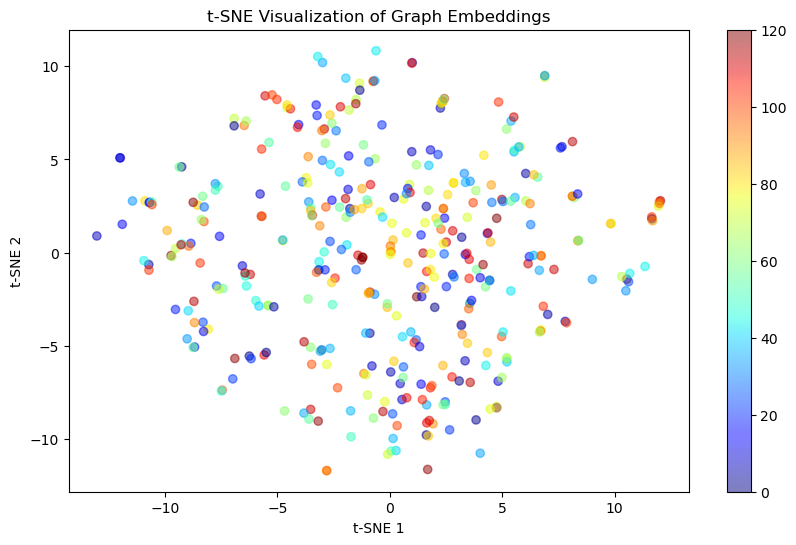

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(model, data, num_points=1000):
    model.eval()
    with torch.no_grad():
        out = model(data)
        # Get the embeddings from the last layer before softmax
        embeddings = out.detach().cpu().numpy()

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings[:num_points])

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=data.y[:num_points].detach().cpu().numpy(), cmap='jet', alpha=0.5)
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Graph Embeddings")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()

# Call the visualization function
visualize_embeddings(model, data)
